In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.models import resnet18

from data import get_bloodmnist_loader
from utils import *

!nvidia-smi

/h/lkcai/anaconda3/envs/video_comp_py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Thu Nov 28 18:26:41 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:86:00.0 Off |                    0 |
| N/A   47C    P0    29W /  70W |   3505MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
train_loader = get_bloodmnist_loader(split='train', batch_size=64, shuffle=True)
val_loader = get_bloodmnist_loader(split='val', batch_size=100, shuffle=False)

Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz
Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz


In [17]:
num_classes = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()

criterion = nn.CrossEntropyLoss()

parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
optimizer = optim.Adam(parameters, 0.01)

model = model.to(device)

val_acc = validate(model, val_loader, device)
print(f"ResNet18 without pretraining - Val Acc: {val_acc:.2f}% ")

ResNet18 without pretraining - Val Acc: 7.13% 


100%|██████████| 187/187 [00:47<00:00,  3.94it/s]


[Epoch 1/10]: Train Loss: 1.4106 Train Acc: 50.66% | Val Acc: 52.10%


100%|██████████| 187/187 [00:46<00:00,  4.01it/s]


[Epoch 2/10]: Train Loss: 1.0590 Train Acc: 62.56% | Val Acc: 47.49%


100%|██████████| 187/187 [00:47<00:00,  3.93it/s]


[Epoch 3/10]: Train Loss: 0.9054 Train Acc: 67.88% | Val Acc: 80.43%


100%|██████████| 187/187 [00:46<00:00,  4.01it/s]


[Epoch 4/10]: Train Loss: 0.7644 Train Acc: 72.95% | Val Acc: 84.11%


100%|██████████| 187/187 [00:46<00:00,  4.04it/s]


[Epoch 5/10]: Train Loss: 0.6643 Train Acc: 76.54% | Val Acc: 77.63%


100%|██████████| 187/187 [00:46<00:00,  4.04it/s]


[Epoch 6/10]: Train Loss: 0.5706 Train Acc: 79.81% | Val Acc: 88.14%


100%|██████████| 187/187 [00:46<00:00,  4.02it/s]


[Epoch 7/10]: Train Loss: 0.4919 Train Acc: 83.08% | Val Acc: 90.42%


100%|██████████| 187/187 [00:45<00:00,  4.08it/s]


[Epoch 8/10]: Train Loss: 0.4473 Train Acc: 84.91% | Val Acc: 86.04%


100%|██████████| 187/187 [00:46<00:00,  4.04it/s]


[Epoch 9/10]: Train Loss: 0.4005 Train Acc: 85.78% | Val Acc: 89.60%


100%|██████████| 187/187 [00:46<00:00,  4.02it/s]


[Epoch 10/10]: Train Loss: 0.3781 Train Acc: 87.08% | Val Acc: 93.22%


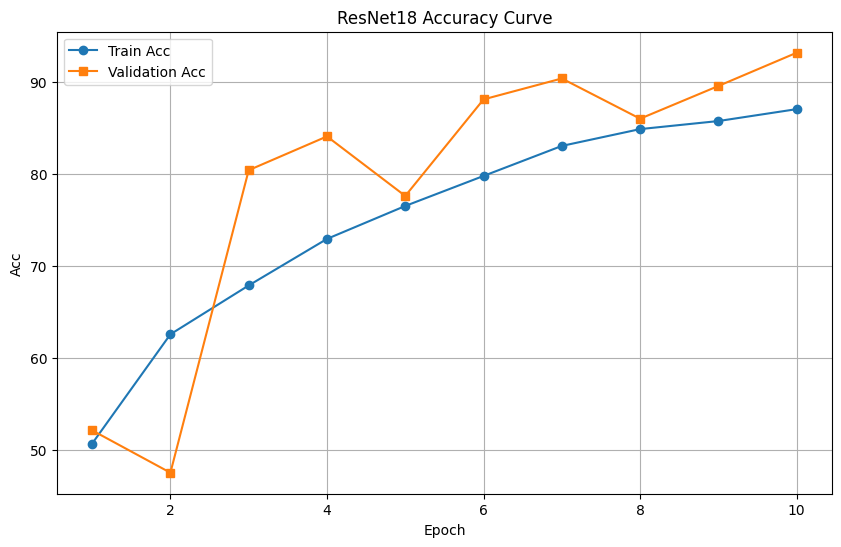

In [18]:
num_epochs = 10

train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc = validate(model, val_loader, device)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Acc', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('ResNet18 Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()

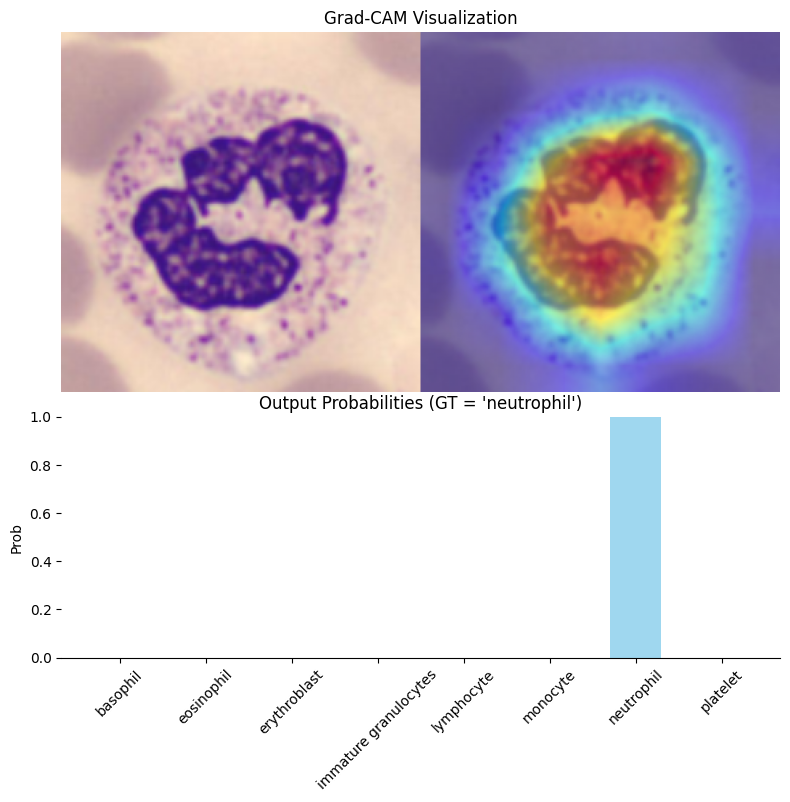

In [19]:
class_names = list(bloodmnist_label.values())

vis_res, output_probs, label = grad_cam_vis(model, val_loader, img_idx=88)

fig, axes = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 2]})

axes[0].imshow(vis_res)
axes[0].axis('off')
axes[0].set_title(f"Grad-CAM Visualization")

axes[1].bar(class_names, output_probs, color='skyblue', alpha=0.8, width=0.6)

axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

axes[1].set_ylim([0, 1])
axes[1].set_ylabel("Prob")
axes[1].set_title(f"Output Probabilities (GT = '{class_names[label]}')")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('vis_results/cam_vis_sup_scratch_res18.png')
plt.show()